In [2]:
import torch
from datasets.augmentations import Compose, CentreCrop, SquareResize, Normalize, ArrayToTensor
from models.force_estimator_2d import ForceEstimatorV, ForceEstimatorVS
from models.force_estimator_transformers import ViT
from path import Path
from datasets.vision_state_dataset import normalize_labels, load_as_float
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/md21local/miniconda3/envs/py3.11/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Define the folder to be analysed
folder_dir = "/home/md21local/test_force_visu_data/eco_30_pink_dragon_20_pink_double-layer_push"
folder_dir = Path(folder_dir)

labels = np.array(pd.read_csv(folder_dir/"labels.csv"))
norm_labels = normalize_labels(labels)

forces = labels[:, -6:]

inputs = []
n_labels = labels.shape[0] // len(folder_dir.files('*.png'))
step = 7

for i, img_file in enumerate(sorted(folder_dir.files('*.png'))):
    if i == 1220:
        break

    if i > 20:
        data = {}
        img = load_as_float(img_file)
        state = norm_labels[i*n_labels:(i*n_labels) + step, :-6]
        force = labels[i*n_labels:(i*n_labels) + step, -6:]
        data['img'] = img
        data['state'] = state
        data['force'] = 0.1 * force
        inputs.append(data)

In [3]:
#Define the transformation for the images
normalize = Normalize(mean = [0.45, 0.45, 0.45],
                    std = [0.225, 0.225, 0.225])
transform = Compose(
    [CentreCrop(), 
    SquareResize(),
    ArrayToTensor(),
    normalize])

In [42]:
# Load the model you want to test, uncommet for it

# VISION ONLY CNN #
cnn_visual = ForceEstimatorV(final_layer=6)
cnn_visual_checkpoint = torch.load('/home/md21local/mreyzabal/checkpoints/img2force/cnn/visu/01-27-09:50/checkpoint.pth.tar')
cnn_visual.load_state_dict(cnn_visual_checkpoint['state_dict'], strict=False)

# VISION AND STATE CNN #
cnn_state = ForceEstimatorVS(rs_size=25, final_layer=30)
cnn_state_checkpoint = torch.load('/home/md21local/mreyzabal/checkpoints/img2force/cnn/visu_state/01-27-09:50/checkpoint.pth.tar')
cnn_state.load_state_dict(cnn_state_checkpoint['state_dict'], strict=False)

cnn_visual.eval()
cnn_state.eval()

# VISION ONLY VIT #
# vit_visual = ViT(
#             image_size = 256,
#             patch_size = 16,
#             num_classes = 6,
#             dim = 1024,
#             depth = 6,
#             heads = 16,
#             mlp_dim = 2048,
#             dropout = 0.1,
#             emb_dropout = 0.1,
#             max_tokens_per_depth=(256, 128, 64, 32, 16, 8),
#             state_include = False
# )
# vit_visual_checkpoint = torch.load('/home/md21local/mreyzabal/checkpoints/img2force/vit/visu/01-27-10:36/checkpoint.pth.tar')
# vit_visual.load_state_dict(vit_visual_checkpoint['state_dict'], strict=False)

# # VISION AND STATE VIT #
# vit_state = ViT(
#             image_size = 256,
#             patch_size = 16,
#             num_classes = 6,
#             dim = 1024,
#             depth = 6,
#             heads = 16,
#             mlp_dim = 2048,
#             dropout = 0.1,
#             emb_dropout = 0.1,
#             max_tokens_per_depth=(256, 128, 64, 32, 16, 8),
#             state_include = True
# )
# vit_state_checkpoint = torch.load('/home/md21local/mreyzabal/checkpoints/img2force/vit/visu_state/01-27-09:50/checkpoint.pth.tar')
# vit_state.load_state_dict(vit_state_checkpoint['state_dict'], strict=False)

# vit_state.eval()
# vit_visual.eval()

ForceEstimatorVS(
  (encoder): ResNet18(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (relu): ReLU()
    (layer1): Sequential(
      (0): ResBlock2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Sequential()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU()
        (relu2): ReLU()
        (relu_last): ReLU()
      )
      (1): ResBlock2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shor

In [43]:
visu_forces = []
state_forces = []
visu_rmse = []
state_rmse = []
forces = []

for i, inp in enumerate(inputs):
    if i == 600: 
        break
    state = torch.from_numpy(inp['state']).unsqueeze(0).float()
    force = torch.from_numpy(inp['force']).unsqueeze(0).float()
    img = transform([inp['img']])[0]

    pred_force_visu = cnn_visual(img.unsqueeze(0))
    pred_force_state = torch.zeros(*force.shape)
    for i in range(pred_force_state.shape[1]):
        s = state[:, i, :]
        pred_force_state[:, i, :] = cnn_state(img.unsqueeze(0), s)

    rmse_visu = torch.sqrt(((force.mean(axis=1) - pred_force_visu) ** 2).mean())
    rmse_state = torch.sqrt(((force - pred_force_state) ** 2).mean())

    visu_rmse.append(rmse_visu.item())
    state_rmse.append(rmse_state.item())
    visu_forces.append(pred_force_visu.squeeze(0).detach().numpy())
    state_forces.append([f for f in pred_force_state.squeeze(0).detach().numpy()])
    forces.append([f for f in force.squeeze(0).detach().numpy()])

visu_rmse = np.array(visu_rmse)
state_rmse = np.array(state_rmse)
visu_forces = np.array(visu_forces)
state_forces = np.array(state_forces).reshape(-1, 6)
forces = np.array(forces).reshape(-1, 6)

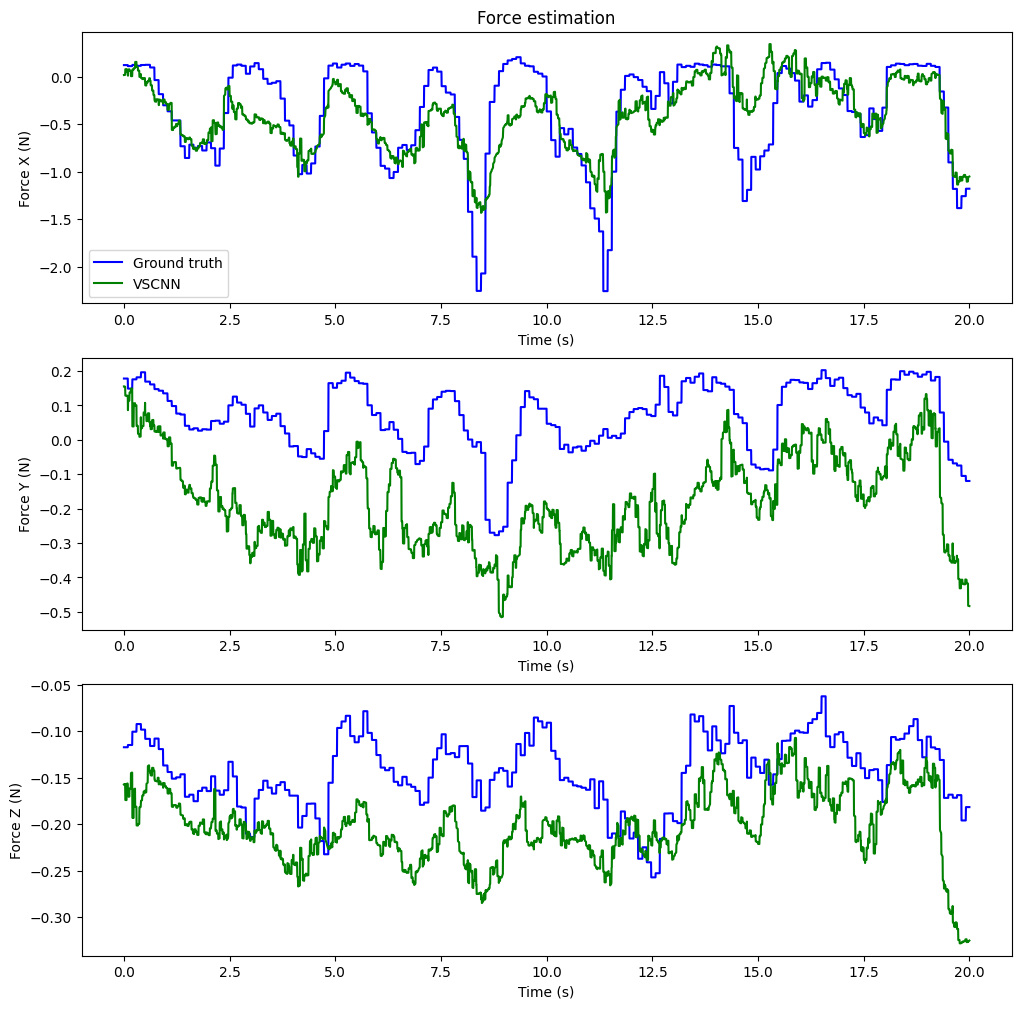

In [48]:
state_x = (1/30)*np.linspace(0, len(visu_forces), len(state_forces))
visu_x = (1/30)*np.linspace(0, len(visu_forces), len(visu_forces))

fig = plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(state_x, forces[:, 0], 'b')
# plt.plot(visu_x, visu_forces[:, 0], 'r')
plt.plot(state_x, state_forces[:, 0], 'g')
plt.legend(["Ground truth", "VSCNN"])
plt.xlabel("Time (s)")
plt.ylabel("Force X (N)")
plt.title("Force estimation")
plt.subplot(3, 1, 2)
plt.plot(state_x, forces[:, 1], 'b')
# plt.plot(visu_x, visu_forces[:, 1], 'r')
plt.plot(state_x, state_forces[:, 1], 'g')
plt.xlabel("Time (s)")
plt.ylabel("Force Y (N)")
plt.subplot(3, 1, 3)
plt.plot(state_x, forces[:, 2], 'b')
# plt.plot(visu_x, visu_forces[:, 2], 'r')
plt.plot(state_x, state_forces[:, 2], 'g')
plt.xlabel("Time (s)")
plt.ylabel("Force Z (N)")
fig.savefig('figures/pre-results_cnn.png', dpi=800)

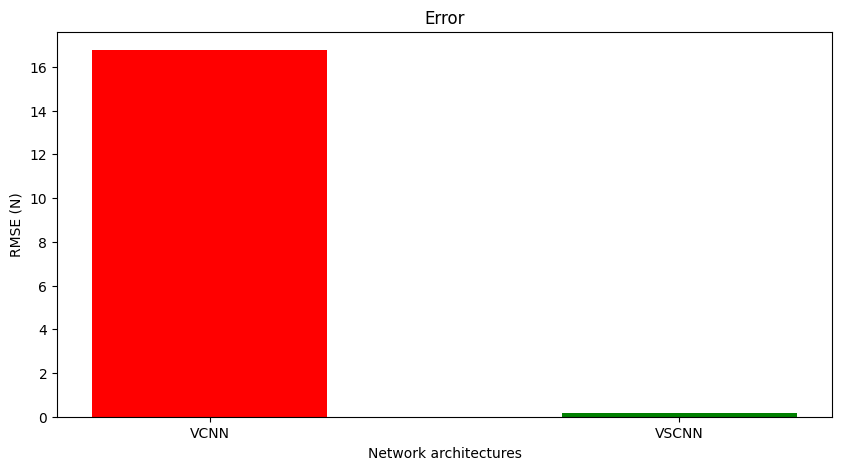

In [47]:
name = ['VCNN', 'VSCNN']
rmse_values = [visu_rmse.mean(), state_rmse.mean()]
fig = plt.figure(figsize = (10, 5))
plt.bar(name[0], rmse_values[0], color='red', width=0.5)
plt.bar(name[1], rmse_values[1], color='green', width=0.5)
plt.xlabel('Network architectures')
plt.ylabel('RMSE (N)')
plt.title('Error')
fig.savefig('figures/pre-errors_cnn.png', dpi=800)

In [3]:
import pickle

save_dic = {'visu_rmse': visu_rmse, 'state_rmse': state_rmse, 'visu_force': visu_forces, 'state_force': state_forces}
f = open("results/cnn.pkl", "wb")
pickle.dump(save_dic, f)
f.close()

NameError: name 'visu_rmse' is not defined

In [10]:
cnn_file = open('results/cnn.pkl', 'rb')
cnn_data = pickle.load(cnn_file)

vit_file = open('results/transformers.pkl', 'rb')
vit_data = pickle.load(vit_file)


NameError: name 'state_x' is not defined

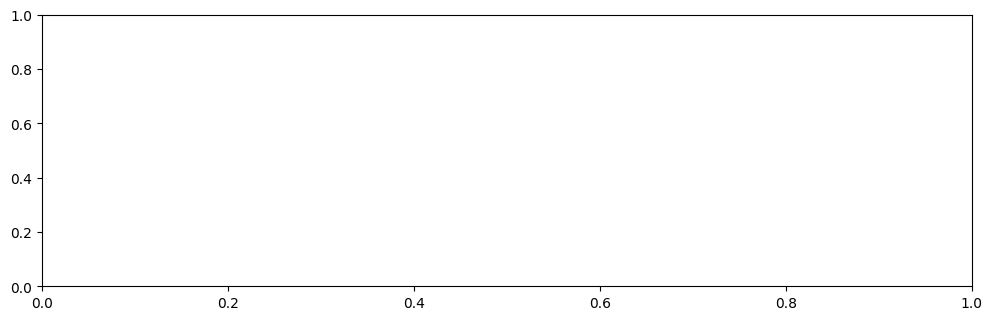

In [11]:
vit_state_force = vit_data['state_force']
cnn_state_force = cnn_data['state_force']

fig = plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(state_x, forces[:, 0], 'b')
plt.plot(state_x, cnn_state_force[:, 0], 'r')
plt.plot(state_x, vit_state_force[:, 0], 'g')
plt.legend(["Ground truth", "VSCNN", "ViST"])
plt.xlabel("Time (s)")
plt.ylabel("Force X (N)")
plt.title("Force estimation")
plt.subplot(3, 1, 2)
plt.plot(state_x, forces[:, 1], 'b')
plt.plot(state_x, cnn_state_force[:, 1], 'r')
plt.plot(state_x, vit_state_force[:, 1], 'g')
plt.xlabel("Time (s)")
plt.ylabel("Force Y (N)")
plt.subplot(3, 1, 3)
plt.plot(state_x, forces[:, 2], 'b')
plt.plot(state_x, cnn_state_force[:, 2], 'r')
plt.plot(state_x, vit_state_force[:, 2], 'g')
plt.xlabel("Time (s)")
plt.ylabel("Force Z (N)")
fig.savefig('figures/pre-results.png', dpi=800)

In [16]:
# Create a video with the force estimation and the video

from matplotlib.gridspec import GridSpec
import matplotlib.animation as animation

fig = plt.figure(figsize=(10, 10))
state_x = np.linspace(0, 600, len(cnn_state_force))

gs = GridSpec(2, 1, height_ratios=[4, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Force (N)")

force = np.array([s['force'] for s in inputs[:600]]).reshape(-1, 6)

def animate(i):
    ax1.imshow((255. * inputs[i]['img']).astype(np.uint8))
    ax1.set_title("Video")
    ax2.plot(state_x[:(i+1)*7], force[:(i+1)*7, 0], 'b')
    ax2.plot(state_x[:(i+1)*7], cnn_state_force[:(i+1)*7, 0], 'r')
    ax2.plot(state_x[:(i+1)*7], vit_state_force[:(i+1)*7, 0], 'g')
    ax2.legend(['Ground truth', 'VSCNN', 'ViST'])

ani = animation.FuncAnimation(
    fig, animate, frames=100)

ani.save("results/force_pred.mp4")

MovieWriter ffmpeg unavailable; using Pillow instead.


(4200, 6)
